,order_id,customer_id,region,amount,order_date,notes
0,1001,11,Pune,"25,000",2025-03-11,ok
1,1002,21,Mumbai,"15,000",2025/05/03,
2,1003,11,Pune,NaN,11-04-2025,refund
3,1004,33,Nagpur,"28,000",2025-04-01,ok
4,1005,21,Mumbai,"15,000",2025-05-03,



CLEANED DATA


,order_id,customer_id,region,amount_clean,order_date,month,is_refund
0,1001,11,Pune,25000.0,2025-03-11,2025-03,False
1,1002,21,Mumbai,15000.0,2025-05-03,2025-05,False
3,1004,33,Nagpur,28000.0,2025-04-01,2025-04,False
4,1005,21,Mumbai,15000.0,2025-05-03,2025-05,False
5,1006,44,Pune,52000.0,2025-08-12,2025-08,False
6,1007,11,Pune,26000.0,2025-09-01,2025-09,False
8,1009,44,Pune,18000.0,2025-07-01,2025-07,False
9,1010,55,Mumbai,23000.0,2025-06-15,2025-06,False



KPIs
Total Revenue (positive amounts): 202000.0
Total Refunds (negative amounts): 0.0
Net Revenue: 202000.0


,region,net_amount
0,Mumbai,53000.0
1,Nagpur,28000.0
2,Pune,121000.0


,customer_id,net_amount
3,44,70000.0
0,11,51000.0
1,21,30000.0
2,33,28000.0
4,55,23000.0


,month,net_amount
0,2025-03,25000.0
1,2025-04,28000.0
2,2025-05,30000.0
3,2025-06,23000.0
4,2025-07,18000.0
5,2025-08,52000.0
6,2025-09,26000.0


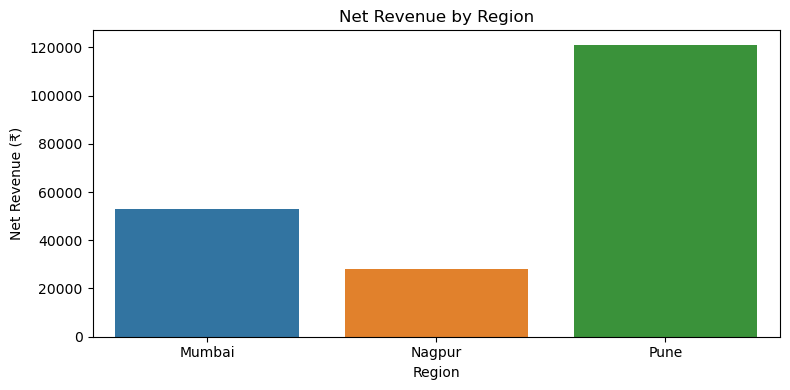

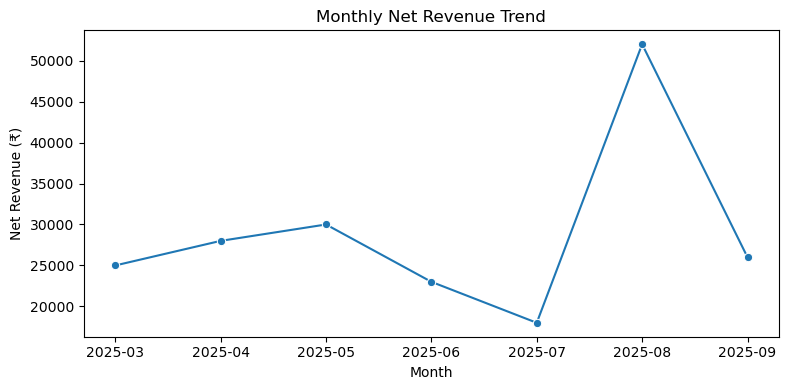

In [1]:
# Day 7 — End-to-End Case Study (Python)
# Notebook: day7_case_study.ipynb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Ensure reports folder exists
Path("reports").mkdir(parents=True, exist_ok=True)

# ---------------------------
# 1) Simulate a raw-ish dataset
# ---------------------------
raw = {
    "order_id": [1001,1002,1003,1004,1005,1006,1007,1008,1009,1010],
    "customer_id": [11,21,11,33,21,44,11,33,44,55],
    "region": ["Pune","Mumbai","Pune","Nagpur","Mumbai","Pune",None,"Nagpur","Pune","Mumbai"],
    "amount": ["25,000","15,000","NaN","28,000","15,000","52000","26000","NaN","18000","23000"],
    "order_date": ["2025-03-11","2025/05/03","11-04-2025","2025-04-01","2025-05-03","2025-08-12","2025-09-01","2025-04-30","2025-07-01","2025-06-15"],
    "notes": ["ok","","refund","ok","","late","ok","ok","discount",""]
}
df = pd.DataFrame(raw)
display(df.head())

# ---------------------------
# 2) Cleaning steps
# ---------------------------
# a) Normalize amount: remove commas, convert to numeric, coerce errors
df['amount_clean'] = (df['amount']
                      .str.replace(',', '')
                      .replace('NaN', np.nan)
                      .replace('', np.nan))
df['amount_clean'] = pd.to_numeric(df['amount_clean'], errors='coerce')

# b) Fill small missing region from known customer mapping (if we had it)
customer_region_map = {11: "Pune", 21:"Mumbai", 33:"Nagpur", 44:"Pune", 55:"Mumbai"}
df['region'] = df['region'].fillna(df['customer_id'].map(customer_region_map))

# c) Standardize date to datetime
df['order_date'] = pd.to_datetime(df['order_date'], dayfirst=False, errors='coerce')

# d) Flag refunds / negative amounts if notes contain 'refund'
df['is_refund'] = df['notes'].str.contains('refund', case=False, na=False)
# For refunds set amount negative
df.loc[df['is_refund'], 'amount_clean'] = -abs(df.loc[df['is_refund'], 'amount_clean'])

# e) Drop rows with missing amount (if business rule)
df_clean = df.dropna(subset=['amount_clean']).copy()

# f) Add month column for aggregation
df_clean['month'] = df_clean['order_date'].dt.to_period('M').astype(str)

# Show cleaned DF
print("\nCLEANED DATA")
display(df_clean[['order_id','customer_id','region','amount_clean','order_date','month','is_refund']])

# ---------------------------
# 3) Compute KPIs (Python)
# ---------------------------
# Total revenue (sum of positive amounts), total refunds (sum negative), net revenue
total_revenue = df_clean.loc[df_clean['amount_clean']>0, 'amount_clean'].sum()
total_refund = df_clean.loc[df_clean['amount_clean']<0, 'amount_clean'].sum()
net_revenue = df_clean['amount_clean'].sum()

# Revenue per region
rev_by_region = df_clean.groupby('region')['amount_clean'].sum().reset_index().rename(columns={'amount_clean':'net_amount'})

# Top customers by net spend
top_customers = (df_clean.groupby('customer_id')['amount_clean']
                 .sum().reset_index()
                 .sort_values('amount_clean', ascending=False)
                 .rename(columns={'amount_clean':'net_amount'}))

# Monthly revenue trend
monthly = (df_clean.groupby('month')['amount_clean']
           .sum().reset_index().rename(columns={'amount_clean':'net_amount'})
           .sort_values('month'))

print("\nKPIs")
print("Total Revenue (positive amounts):", total_revenue)
print("Total Refunds (negative amounts):", total_refund)
print("Net Revenue:", net_revenue)
display(rev_by_region, top_customers, monthly)

# ---------------------------
# 4) Visualizations
# ---------------------------
plt.figure(figsize=(8,4))
sns.barplot(data=rev_by_region, x='region', y='net_amount')
plt.title("Net Revenue by Region")
plt.xlabel("Region")
plt.ylabel("Net Revenue (₹)")
plt.tight_layout()
plt.savefig("reports/day7_net_rev_by_region.png")
plt.show()

plt.figure(figsize=(8,4))
sns.lineplot(data=monthly, x='month', y='net_amount', marker='o')
plt.title("Monthly Net Revenue Trend")
plt.xlabel("Month")
plt.ylabel("Net Revenue (₹)")
plt.tight_layout()
plt.savefig("reports/day7_monthly_trend.png")
plt.show()

# ---------------------------
# 5) Export cleaned data + KPIs
# ---------------------------
df_clean.to_csv("reports/day7_cleaned_orders.csv", index=False)
rev_by_region.to_csv("reports/day7_rev_by_region.csv", index=False)
top_customers.to_csv("reports/day7_top_customers.csv", index=False)
monthly.to_csv("reports/day7_monthly.csv", index=False)


